In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import sys

sys.path.append("..")

from src.utils import read_yaml, read_tiff, save_yaml
from src.metrics import evaluate_metrics,evaluate_component_metrics

# from main import compile_metrics

import os

import pandas as pd
import numpy as np

import shutil

from glob import glob

In [17]:
import seaborn as sns

import matplotlib.pyplot as plt

import yaml
sns.set_style("whitegrid")

## Utils

In [19]:
args = read_yaml("../args.yaml")

# Carregando Métricas

In [20]:
ROOT_PATH = "/home/luiz/multi-task-fcn/"
version_folders = pd.Series(os.listdir(ROOT_PATH))
version_folders = version_folders[version_folders.str.endswith("_version_data")].sort_values()

version_folders = ROOT_PATH + version_folders+"/"

In [21]:
test_labels = read_tiff("../input_data/segmentation/samples_A1_test2tif.tif")

In [22]:
def delete_useless_files(current_iter_folder:str):
    
    folder_to_remove = os.path.join(current_iter_folder,"prediction")

    if os.path.exists(folder_to_remove):
        shutil.rmtree(folder_to_remove)
    
    else:
        raise FileExistsError("The path doesnt exist")

In [42]:
def compile_metrics(current_iter_folder, args):
    # read test segmentation 
    # f'join_class_itc{args.test_itc}_{np.sum(args.overlap)}.TIF'
    DATA_PATH = os.path.dirname(current_iter_folder)

    GROUND_TRUTH_TEST_PATH = os.path.join(DATA_PATH, args.test_segmentation_path)
    ground_truth_test = read_tiff(GROUND_TRUTH_TEST_PATH)

    GROUND_TRUTH_TRAIN_PATH = os.path.join(DATA_PATH, args.train_segmentation_path)
    ground_truth_train = read_tiff(GROUND_TRUTH_TRAIN_PATH)

    PRED_PATH = glob(os.path.join(current_iter_folder, "raster_prediction", f"join_class_itc*.TIF"))[0]
    print(f'\t {PRED_PATH}')

    predicted_seg = read_tiff(PRED_PATH)

    metrics_test = evaluate_metrics(predicted_seg, ground_truth_test)
    
    save_yaml(metrics_test, os.path.join(current_iter_folder,'test_metrics.yaml'))
    

    metrics_train = evaluate_metrics(predicted_seg, ground_truth_train, args.nb_class)

    save_yaml(metrics_train, os.path.join(current_iter_folder,'train_metrics.yaml'))
        


metrics_raw = []
labels_metrics_raw = []

for version_folder in version_folders.values:

    iter_folders =  pd.Series(os.listdir(version_folder))

    iter_folders = iter_folders[iter_folders.str.startswith("iter_") & ~ iter_folders.str.endswith("000")]
    
    iter_folders = version_folder+iter_folders
    
    iter_folders = iter_folders.sort_values().tolist()
    
    iter_folders.pop()
    
    for iter_folder in iter_folders:
        # generate component metrics
        print(iter_folder)
        labels_test_metrics = os.path.join(iter_folder,'all_labels_test_metrics.yaml')
        
        # # selected_labels = read_tiff(os.path.join(iter_folder, "new_labels", "selected_labels_set.tif"))
        # all_labels = read_tiff(os.path.join(iter_folder, "new_labels", "all_labels_set.tif"))

        # all_labels_metrics = evaluate_component_metrics(test_labels, all_labels, 14)
    
        # save_yaml(all_labels_metrics, labels_test_metrics)

        compile_metrics(iter_folder, args)

        test_metrics = os.path.join(iter_folder, "test_metrics.yaml")
        
        iter_metric = read_yaml(test_metrics)
        
        iter_metric['iter_folder'] = iter_folder
        
        metrics_raw.append(iter_metric)



        labels_test_metrics = os.path.join(iter_folder,'all_labels_test_metrics.yaml')
        
        label_iter_metric = read_yaml(labels_test_metrics)
        
        label_iter_metric["iter_folder"] = iter_folder

        labels_metrics_raw.append(label_iter_metric)

        
    

/home/luiz/multi-task-fcn/1.0_version_data/iter_001
	 /home/luiz/multi-task-fcn/1.0_version_data/iter_001/raster_prediction/join_class_itcFalse_1.1.TIF
/home/luiz/multi-task-fcn/1.0_version_data/iter_002
	 /home/luiz/multi-task-fcn/1.0_version_data/iter_002/raster_prediction/join_class_itcFalse_1.1.TIF
/home/luiz/multi-task-fcn/10.0_version_data/iter_001
	 /home/luiz/multi-task-fcn/10.0_version_data/iter_001/raster_prediction/join_class_itcFalse_1.1.TIF
/home/luiz/multi-task-fcn/10.0_version_data/iter_002
	 /home/luiz/multi-task-fcn/10.0_version_data/iter_002/raster_prediction/join_class_itcFalse_1.1.TIF
/home/luiz/multi-task-fcn/10.0_version_data/iter_003
	 /home/luiz/multi-task-fcn/10.0_version_data/iter_003/raster_prediction/join_class_itcFalse_1.1.TIF
/home/luiz/multi-task-fcn/10.0_version_data/iter_004
	 /home/luiz/multi-task-fcn/10.0_version_data/iter_004/raster_prediction/join_class_itcFalse_1.1.TIF
/home/luiz/multi-task-fcn/10.0_version_data/iter_005
	 /home/luiz/multi-task-fcn

IndexError: list index out of range

In [ ]:
df_metrics = pd.DataFrame(metrics_raw)

df_metrics["version"] = df_metrics['iter_folder'].str.split("/").str[-2].str.split("_").str[0].astype(float)

df_metrics["iter"] = df_metrics['iter_folder'].str.split("/").str[-1].str.split("_").str[-1].astype(int)

df_metrics.sort_values(["version", 'iter'], inplace = True)

In [ ]:
df_label_metrics = pd.DataFrame(labels_metrics_raw)

df_label_metrics["version"] = df_label_metrics['iter_folder'].str.split("/").str[-2].str.split("_").str[0].astype(float)

df_label_metrics["iter"] = df_label_metrics['iter_folder'].str.split("/").str[-1].str.split("_").str[-1].astype(int)

df_label_metrics.sort_values(["version", "iter"], inplace = True)

# Visões comparativas

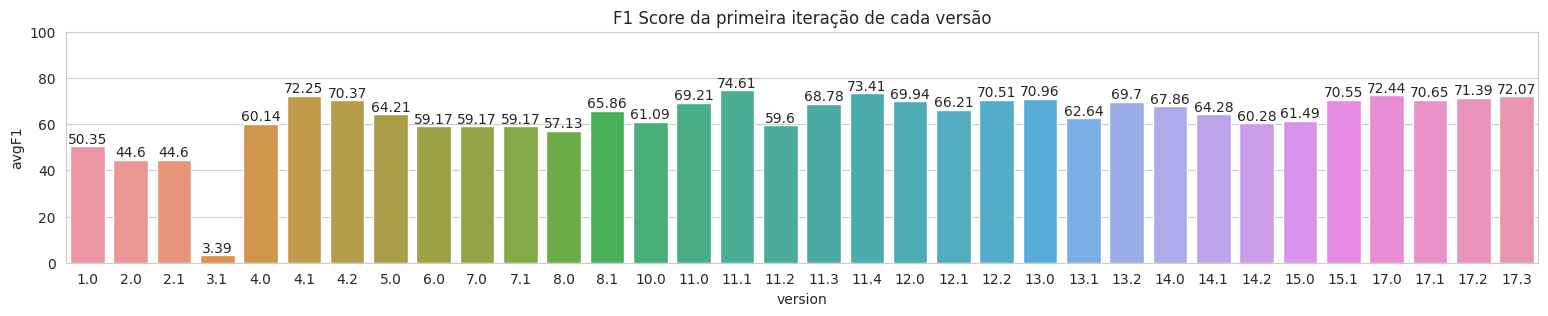

In [ ]:
plt.figure(figsize= (df_metrics["iter"].nunique(), 3))

g = sns.barplot(
    data = df_metrics[df_metrics["iter"] == 1],
    x = "version",
    y = "avgF1"
)

g.set_title("F1 Score da primeira iteração de cada versão")
g.bar_label(g.containers[0])

plt.ylim(0, 100)

plt.show()

- Modelo Usado:
    - DeepVlab3+

Com base nesses resultados, temos um panorama de quais testes melhoraram os resultados do modelo na primeira iteração:

Sobre alterações que impactam a primeira iteração do modelo:

- 1.0 : Normalização por Standadrd Scaler
- 3.0 : Mudança da loss para focal loss com gamma 2

- 4.0 : Data Augmentation: 
        Random Flip, Random Rotate e Random Crop Sem Resize

- 5.0 : Inícios dos pesos aleatoriamente
- 12.0 : Uso da Focal Loss com gamma 1.5
- 13.0 : Uso de dropout na task de classificação e na task auxiliar
- 14.2 :  Diminuição do filtro gaussiano do primeiro distance map de 5 para 1.

In [ ]:
df_metrics["diffF1"] = df_metrics.groupby(["version"])["avgF1"].diff()

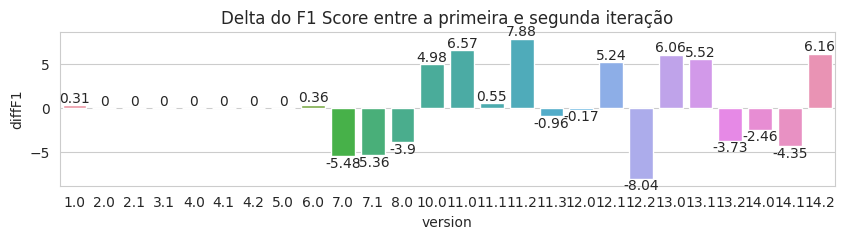

In [ ]:
plt.figure(figsize= (10, 2))

g = sns.barplot(
    data = df_metrics[df_metrics["iter"] == 2],
    x = "version",
    y = "diffF1"
)

g.set_title("Delta do F1 Score entre a primeira e segunda iteração")

g.bar_label(g.containers[0])

plt.show()


In [ ]:
df_metrics[(df_metrics["version"] >= 10) & (df_metrics["iter"] <= 5)]

,Accuracy,avgF1,avgPre,avgRec,iter_folder,version,iter,diffF1
2,62.54,61.09,70.25,64.53,/home/luiz/multi-task-fcn/10.0_version_data/it...,10.0,1,NaN
3,69.03,66.07,74.58,68.85,/home/luiz/multi-task-fcn/10.0_version_data/it...,10.0,2,4.98
4,65.68,60.19,68.88,65.45,/home/luiz/multi-task-fcn/10.0_version_data/it...,10.0,3,-5.88
5,65.54,63.25,74.92,64.63,/home/luiz/multi-task-fcn/10.0_version_data/it...,10.0,4,3.06
6,61.14,57.98,66.25,62.32,/home/luiz/multi-task-fcn/10.0_version_data/it...,10.0,5,-5.27
...,...,...,...,...,...,...,...,...
91,69.66,66.44,76.00,72.36,/home/luiz/multi-task-fcn/14.2_version_data/it...,14.2,2,6.16
92,67.57,67.48,77.98,72.16,/home/luiz/multi-task-fcn/14.2_version_data/it...,14.2,3,1.04
93,62.72,62.21,73.85,67.17,/home/luiz/multi-task-fcn/14.2_version_data/it...,14.2,4,-5.27
94,66.85,65.78,78.53,69.68,/home/luiz/multi-task-fcn/14.2_version_data/it...,14.2,5,3.57


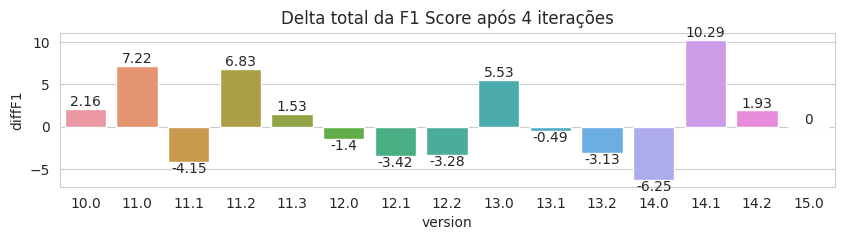

In [ ]:
plt.figure(figsize= (10, 2))

g = sns.barplot(
    data = df_metrics[(df_metrics["version"] >= 10) & (df_metrics["iter"] <= 4)].groupby("version", as_index=False)["diffF1"].sum(),
    x = "version",
    y = "diffF1"
)
g.set_title("Delta total da F1 Score após 4 iterações")
g.bar_label(g.containers[0])

plt.show()


Versão 10.0:
- Mapa de probabilidade (filtro_gaussiando) + Mapa de Distâncias (filtro_gaussiando) > 1.2
- Início do modelo com pesos da imagenet

Versão 11.0:
- Seleção prévia dos componentes com probabilidade maior que 0.95
- Uso do filtro (distance_map+probability_map) > 1.3
- Random rotate limitado a 0, 90, 180, 270

Versão 12.0
- Mudança do Gamma da Focal Loss para 1.5

Versão 13.0
- Uso de dropout até 0.65 nos classificadores

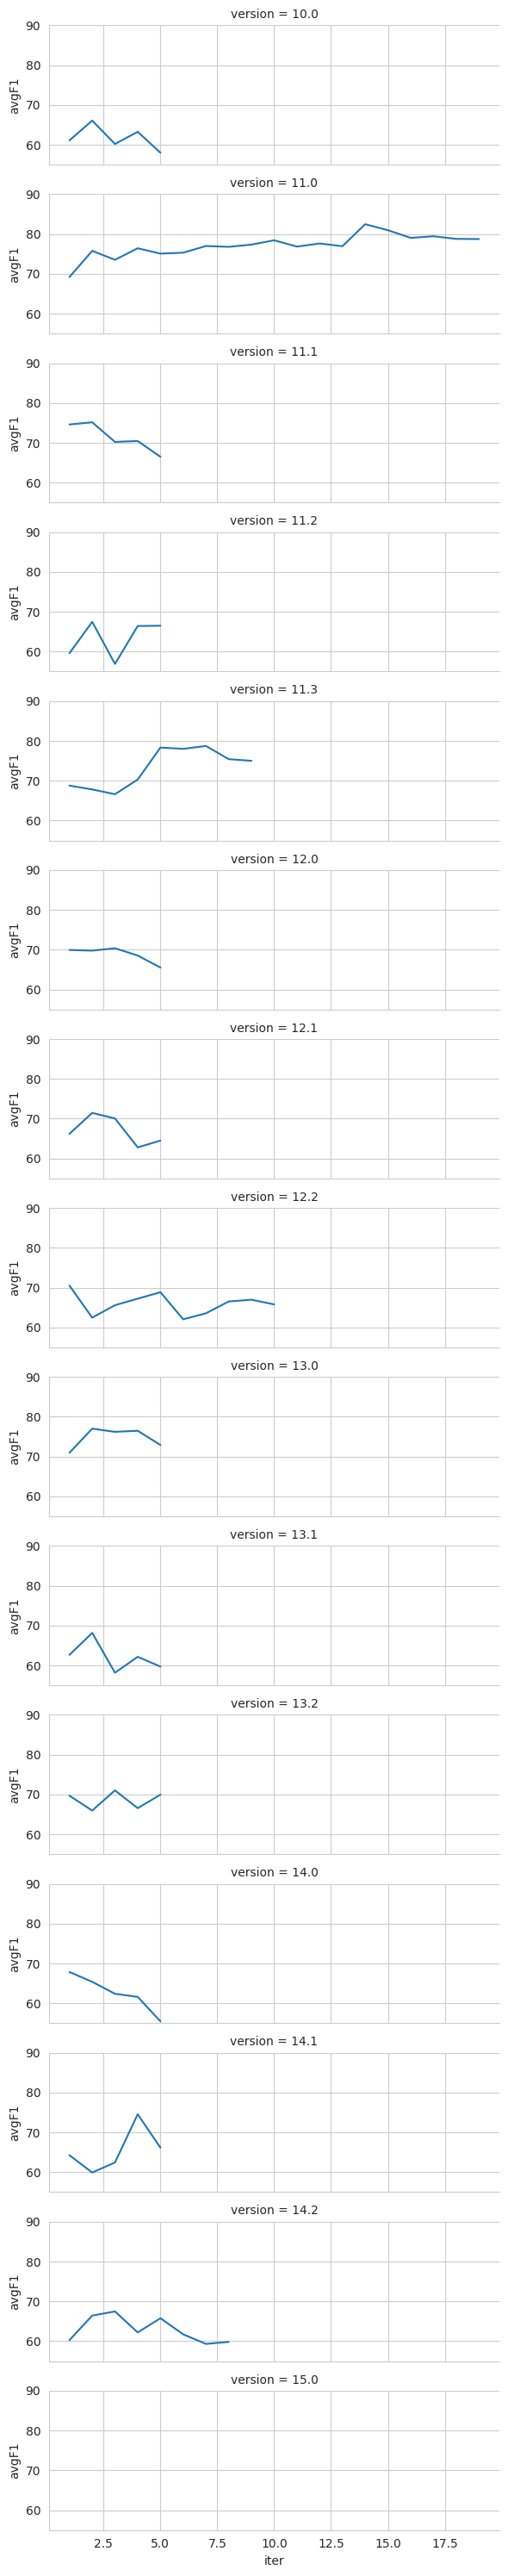

In [ ]:
g = sns.FacetGrid(
    df_metrics[df_metrics["version"]>=10],
    row = "version",
    height = 2,
    aspect = 3,
    # xlim=(1,10),
    ylim=(55, 90)
)

g.map(sns.lineplot, "iter", "avgF1")


# Análise das métricas relacionadas a seleção de componentes

Nessas análises focamos em entender se os componentes selecionados com alta confiança pelo modelo estão conseguindo gerar componentes com o formato adequado

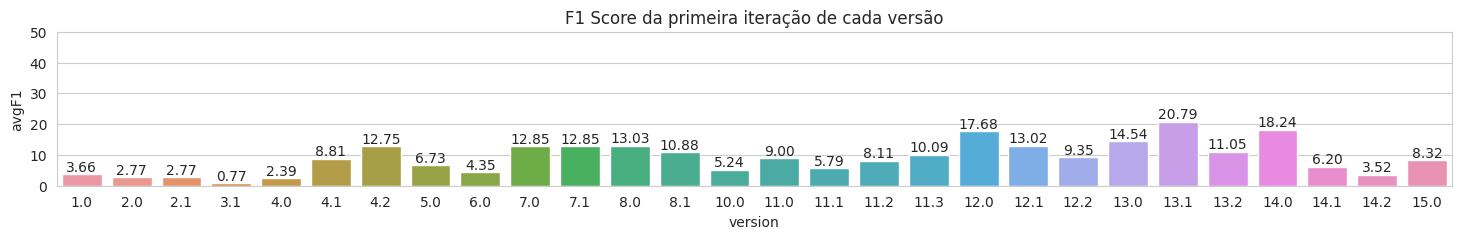

In [ ]:
plt.figure(figsize= (df_label_metrics["version"].nunique()//1.5, 2))

g = sns.barplot(
    data = df_label_metrics[df_label_metrics["iter"] == 1],
    x = "version",
    y = "avgF1"
)

g.set_title("F1 Score da primeira iteração de cada versão")
g.bar_label(g.containers[0], fmt='{:.2f}')

plt.ylim(0, 50)
plt.show()

Apesar da versão 11 ser a única que manteve uma melhora consistente das métricas do modelo, ela obteve uma das mais baixas métrica de seleção de componentes

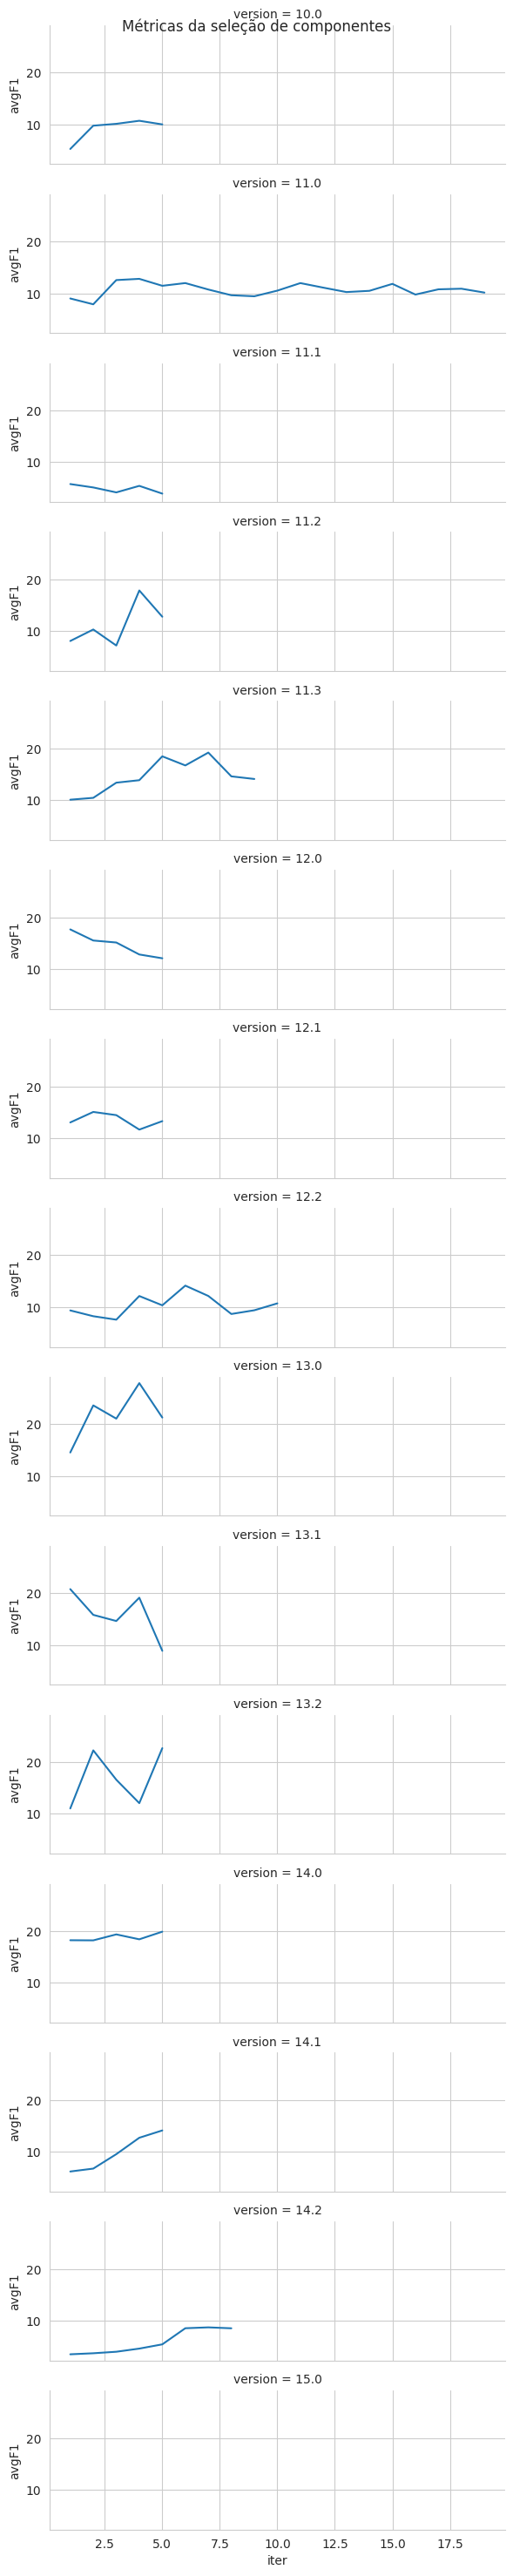

In [ ]:
g = sns.FacetGrid(
    df_label_metrics[df_label_metrics["version"] >= 10],
    row = "version",
    height = 2,
    aspect = 3,
    # xlim=(1,10),
    # ylim=(55, 90)
)

g.fig.suptitle("Métricas da seleção de componentes")
g.map(sns.lineplot, "iter", "avgF1")

plt.tight_layout()
plt.show()